# Wind Grid

Testing our controller on realistic wind generated by MIT LL's wind service.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from utilities import get_agent
from environments import OctorotorEnvSelector
from systems.pid_agent import PIDAgent
from multirotor.helpers import DataLog
from systems.long_blending import softmax

from pymavlink import mavutil
import socket
import struct
import json
from multirotor.coords import body_to_inertial, direction_cosine_matrix

In [2]:
env_selector = OctorotorEnvSelector()
study, lstm_agent, lstm_params = get_agent('windlstm')
lstm_params['steps_u'] = 50
lstm_params['bounding_rect_length']=1000

[I 2023-11-17 11:56:24,022] Using an existing study with name 'windlstm' instead of creating a new one.


In [3]:
wind_data = pd.read_csv("wind_data.csv")

In [4]:
wind_positions = wind_data[['X', 'Y']].to_numpy()

In [5]:
square_np = np.array([[500,0,400], [500,500,400], [0,500,400], [0,0,400]])

In [6]:
def determine_wind(xypos):
    # Calculate the Euclidean distances
    distances = np.linalg.norm(wind_positions - xypos, axis=1)
    
    # Find the index of the position with the smallest distance
    closest_position_index = np.argmin(distances)
    
    # Get the closest position
    wind_vec = wind_data.loc[closest_position_index]
    wind_x = wind_vec['Wind X']
    wind_y = wind_vec['Wind Y']

    return wind_x, wind_y

In [7]:
determine_wind(np.array([0,0]))

(-1.5365558741389316, -9.084663838228057)

In [8]:
sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
sock.bind(("127.0.0.1", 9002))
# sock.settimeout(0.1)

In [9]:
def changeToJSONString(curr_time, state, accel):
    phys_time = curr_time
    pos = state[0:3].tolist()
    pos[2] = 0
    velo = state[3:6]
    euler = state[6:9].tolist()
    gyro = state[9:12].tolist()
    accel = accel.tolist()
    # change reference frame / coordinates to make AP requirements
    pos[2] = -1*pos[2]
    pos[0], pos[1] = pos[1], pos[0]
    dcm = direction_cosine_matrix(*euler).astype(np.float32)
    v_inertial = body_to_inertial(velo, dcm).tolist()
    v_inertial[2] = -1*v_inertial[2]
    v_inertial[0], v_inertial[1] = v_inertial[1], v_inertial[0]
    gyro[0], gyro[1] = gyro[1], gyro[0]
    gyro[2] = -1*gyro[2]
    euler[0], euler[1] = euler[1], euler[0]
    euler[2] = -1*euler[2]
    # Build JSON format
    IMU_fmt = {
        "gyro" : gyro,
        "accel_body" : accel
    }
    JSON_fmt = {
        "timestamp" : phys_time,
        "imu" : IMU_fmt,
        "position" : pos,
        "attitude" : euler,
        "velocity" : v_inertial
    }
    JSON_string = "\n" + json.dumps(JSON_fmt,separators=(',', ':')) + "\n"
    return JSON_string

In [10]:
def sendVelToAP(vx, vy, vz): 
    print("heart beat from system (system %u component %u)" % 
        (mavlink_connection.target_system, mavlink_connection.target_component))
    mavlink_connection.mav.send(mavutil.mavlink.MAVLink_set_position_target_local_ned_message(
        10, mavlink_connection.target_system, mavlink_connection.target_component,
        mavutil.mavlink.MAV_FRAME_LOCAL_NED, int(0b110111000111), 
        0, 0, 0, vx, vy, vz, 0, 0, 0, 0, 0
    ))
    msg = mavlink_connection.recv_match(type = 'LOCAL_POSITION_NED', blocking=True)
    print("vx: %u, vy: %u, vz: %u" % (msg.vx, msg.vy, msg.vz))

In [11]:
client_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
server_address = ('127.0.0.1', 1234)

def send_velocity(vx, vy, vz, client_socket, server_address):
    message = str(vx)+","+str(vy)+","+str(vz)
    message = message.encode('utf-8')
    client_socket.sendto(message, server_address)

In [12]:
def receive_motor_commands():
    data, addr = sock.recvfrom(100)
    parse_format = 'HHI16H'
    magic = 18458
    unpacked_data = struct.unpack(parse_format, data)
    pwm = np.array(unpacked_data[3:11]) # Array of motor commands recieved
    action = (pwm-1000)*0.575 # Translate PWM ESC to motor speeds in rpm
    return action

In [61]:
def send_state(accel, curr_time, state):
    data, addr = sock.recvfrom(100)
    accel[2] = -9.8
    JSON_string = changeToJSONString(curr_time, state, accel)
    # print(JSON_string)
    sock.sendto(bytes(JSON_string,"ascii"), addr)

In [14]:
def build_ap_state(vehicle):
    return np.array([vehicle.position[0], vehicle.position[1], vehicle.position[2],
                    vehicle.velocity[0], vehicle.velocity[1], vehicle.velocity[2],
                    vehicle.orientation[0], vehicle.orientation[1], vehicle.orientation[2],
                    vehicle.angular_rate[0], vehicle.angular_rate[1], vehicle.angular_rate[2]])

In [15]:
# ct = 0
# while True:
#     send_state(np.zeros(3, dtype=np.float32), ct, np.zeros(12, dtype=np.float32))
#     receive_motor_commands()
#     ct += 1/400

In [59]:
# Evaluates all saved agents with their params on a wind range
def run_wind_grid(agent, params):
    env = env_selector.get_env("ardupilot", params, [(0,0),(0,0),(0,0)], square_np, has_turbulence=False, start_alt=400)
    
    done = False
    state = env.reset()
    state = np.array(state, dtype=np.float32)
    log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                      other_vars=('reward',))
    winds = []
    curr_time = 0
    # accel = np.array([0,0,0], dtype=np.float32)
    while not done:
        xy_pos = np.array([env.base_env.vehicle.position[0],env.base_env.vehicle.position[1]])
        # x_wind, y_wind = determine_wind(xy_pos)
        # env.base_env.wind_x = x_wind
        # env.base_env.wind_y = y_wind
        # winds.append([x_wind, y_wind])
        # env.base_env.get_turbulence(env.base_env.prev_waypt, env.base_env.next_waypt)

        pos_ref = env.base_env.calculate_safe_sliding_bound(env.base_env.next_waypt, env.base_env.prev_intersection_point, distance=env.base_env.window_distance)
        xy_target_vel = env.base_env.ctrl.ctrl_p.step(pos_ref[0:2], env.base_env.vehicle.position[0:2], dt=env.base_env.dt)
        z_target_vel = env.base_env.ctrl.ctrl_z.step(pos_ref[2:], env.base_env.vehicle.position[2:], dt=env.base_env.dt)
        target_vel = np.hstack([xy_target_vel, z_target_vel])
        delta_vel = agent.predict(state, deterministic=True)[0]
        print(target_vel+delta_vel)
        
        vx, vy, vz = target_vel + delta_vel
        ap_state = build_ap_state(env.base_env.vehicle)
        # print(ap_state)
        for i in range(200):
            curr_time += 1/400
            send_state(env.base_env.vehicle.acceleration, curr_time, ap_state)
            # print(receive_motor_commands())
            
        # send_state(accel, curr_time, state)
        send_velocity(vx, vy, vz, client_socket, server_address)
        speeds = receive_motor_commands()
        print(speeds)
        state, reward, done, info = env.step(speeds)
        state = np.array(state, dtype=np.float32)
        log.log(reward=reward)
        print(env.base_env.vehicle.position)

    log.done_logging()

    return log, winds

In [62]:
wind_log, winds = run_wind_grid(lstm_agent, lstm_params)

[ 2.96033312  0.0657823  -1.08633523]
[0. 0. 0. 0. 0. 0. 0. 0.]
[-9.090000e-03  4.360000e-03  3.988462e+02]
[ 4.53919327 -0.28703795  0.67258436]
[0. 0. 0. 0. 0. 0. 0. 0.]
[-4.624000e-02  3.833499e-02  3.952414e+02]
[ 3.83280153 -0.52846277  1.04379152]
[0. 0. 0. 0. 0. 0. 0. 0.]
[-1.59860000e-01  1.12110004e-01  3.89185791e+02]
[ 3.90535638 -0.35055031  1.02507517]
[0. 0. 0. 0. 0. 0. 0. 0.]
[-3.2406002e-01  1.8885003e-01  3.8067877e+02]
[ 4.04812968 -0.11722245  1.00069822]
[0. 0. 0. 0. 0. 0. 0. 0.]
[-5.4794002e-01  1.6376007e-01  3.6972025e+02]
[ 4.00795742 -0.14051203  0.98260253]
[0. 0. 0. 0. 0. 0. 0. 0.]
[-8.287200e-01  8.704013e-02  3.563105e+02]
[ 3.87155617 -0.25676244  0.96471432]
[0. 0. 0. 0. 0. 0. 0. 0.]
[-1.0324298e+00 -2.6524866e-02  3.4044733e+02]
[ 3.8128456  -0.09373052  0.93483149]
[0. 0. 0. 0. 0. 0. 0. 0.]
[-1.0924597e+00 -6.6044867e-02  3.2213055e+02]
[3.80807296 0.05941951 0.92235973]
[0. 0. 0. 0. 0. 0. 0. 0.]
[-1.0344050e+00 -8.4524840e-02  3.0136142e+02]
[3.8281100

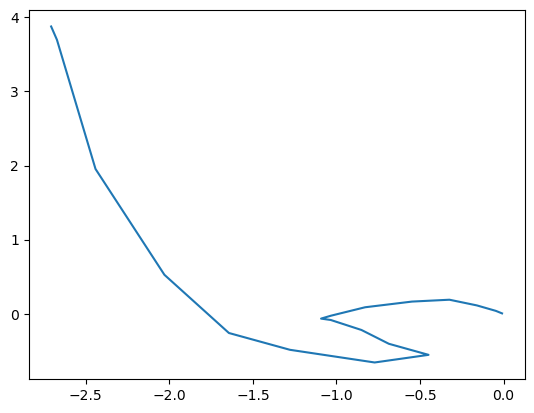

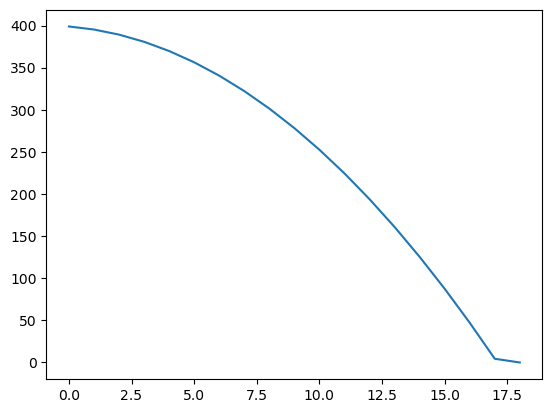

In [64]:
plt.plot(wind_log.x, wind_log.y)
plt.show()
plt.plot(wind_log.z)

In [ ]:
winds = np.array(winds)

Text(0, 0.5, 'Y position (m)')

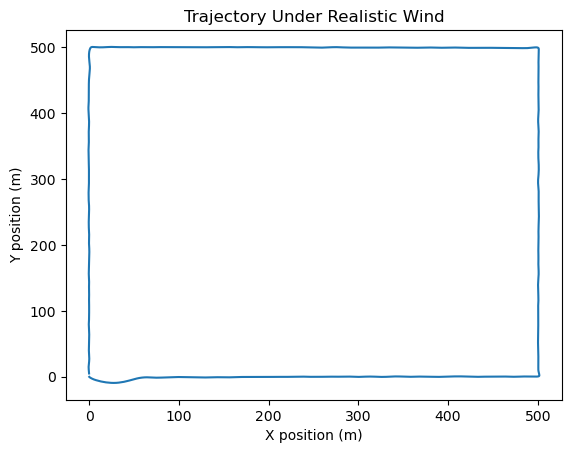

In [54]:
plt.title("Trajectory Under Realistic Wind")
plt.plot(wind_log.x, wind_log.y)
plt.xlabel("X position (m)")
plt.ylabel("Y position (m)")

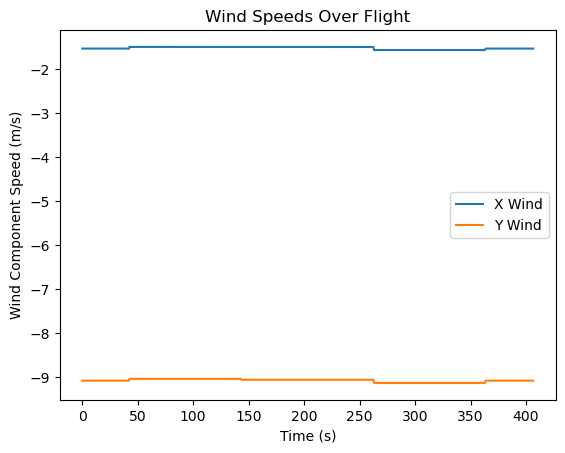

In [64]:
xaxis = np.array(range(len(winds)))/2

plt.title("Wind Speeds Over Flight")
plt.plot(xaxis, winds[:,0], label="X Wind")
plt.plot(xaxis, winds[:,1], label="Y Wind")
plt.xlabel("Time (s)")
plt.ylabel("Wind Component Speed (m/s)")
plt.legend()